In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL-H1/

Mounted at /gdrive
/gdrive/My Drive/ANNDL-H1


# Stuff Tried For Model2
- **model2_Base** -> 55%
- **model2_BatchNormalization** -> 60% accuracy
- **model2_GlobalAvgpooling1** -> Accuracy: 0.6751,Precision: 0.651,Recall: 0.6307,F1: 0.6353
- **model2_GlobalAvgpooling3** -> AccurAccuracy: 0.6469,Precision: 0.6141,Recall: 0.5935,F1: 0.5984
- **model2_GlobalAvgpooling4_MaxPooling** -> AccurAccuracy: 0.655,Precision: 0.6095,Recall: 0.0.6006,F1: 0.6000
- **model2_GlobalAvgpooling4_Batch(no multiConv)**-> AccurAccuracy: 0.678,Precision: 0.6658,Recall: 0.0.6449,F1: 0.6241
- **model2_GlobalAvgpooling6_BestVersion(added batch between dense)**-> AccurAccuracy: 0.6808,Precision: 0.6414,Recall: 0.0.6306,F1: 0.6299 


BAD: Double CONV on first,second layer dosnt work\
BAD: Triple CONV on third and forth dosnt work (stuck to 10%)\
BAD: Droppout after global avg pooling dosnt work\
BAD: Batch Normalization on Convolutions dosnt work well\


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
#!pip install visualkeras
import visualkeras
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
%load_ext autoreload
%autoreload 2

2.10.0


In [ ]:
import sys
sys.path.append('../../../Utils/')
from DatasetHelper import DatasetHelper
from ModelHelper import ModelHelper

## Helper Configuration:
Configure
 the helper classes by setting a seed and the root folder path

In [ ]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../",42) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("../../",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);

# Dataset Loading and Preprocessing

Load dataset and apply all the preprocessing operations
- Splitting
- Normalization
- Augmentation

In [ ]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * X.shape[0]),stratify = Y)

In [ ]:
start = 3000
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
classe = 2
filter_classes = False
for i in range(1, columns*rows +1):
    if not (filter_classes) or np.argmax(Y_train[start+i]) == classe:
        subplot = fig.add_subplot(rows, columns, i)
        subplot.title.set_text('Label: '+ labels[np.argmax(Y_train[start+i])])
        plt.imshow((X_train[start+i]*255).astype(np.uint8))
    else:
        i=i-1
fig.tight_layout()
plt.show()

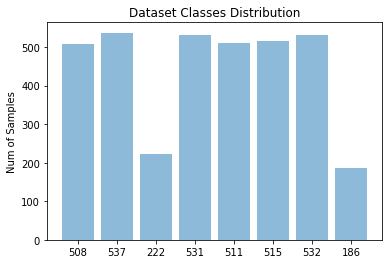

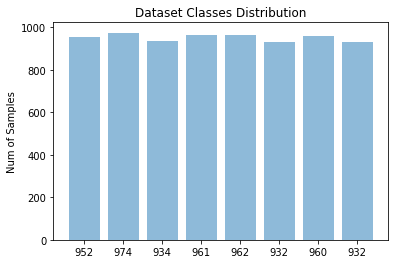

In [ ]:
dataset_helper.plot_samples_distribution(Y)
dataset_helper.plot_samples_distribution(Y_train)

# Define the model Structure
Create a function that declare all the model components

In [ ]:
def stackDenseLayer(layer_name,last_layer,size=256, activation='relu', drop_out = False,drop_rate=0.5,GlorthUniform=False,batch_normalization=False):
    initializer = tfk.initializers.HeUniform(seed)
    if GlorthUniform:
      initializer = tfk.initializers.GlorotUniform(seed)

    dense_layer = tfkl.Dense(
        units=size, 
        name=layer_name, 
        activation=activation,
        kernel_initializer = initializer #Can Be HeUniform(seed) or GlorotUniform(seed)
    )(last_layer)

    #If desired, apply batch normalization
    if batch_normalization:
      dense_layer = tfkl.BatchNormalization(
            axis=-1,
            momentum=0.99,
            epsilon=0.001,
            center=True,
            scale=True,
            beta_initializer="zeros",
            gamma_initializer="ones",
            moving_mean_initializer="zeros",
            moving_variance_initializer="ones"
        )(dense_layer)
    #If desired add droppout
    if drop_out:
        dense_layer = tfkl.Dropout(drop_rate, seed=seed)(dense_layer)
    
    return dense_layer


In [ ]:
def stackConvolutionLayer(layer_name,last_layer,kernel_size = (3,3), num_of_filter = 32,strides= (1,1),activation = 'relu',padding = 'same',pooling_size=(2,2),batch_normalization=False,num_of_stacked_conv=1,Pool=True,PoolAvg=False):
    layer_activation = activation
    
    for i in range(0,num_of_stacked_conv):
        curr_name = layer_name + "_conv" + str(i)
        
        if batch_normalization and i == num_of_stacked_conv - 1:
            activation = None

        curr_conv =tfkl.Conv2D(
            filters=num_of_filter,
            kernel_size=kernel_size,
            strides = strides,
            padding = padding,
            activation = layer_activation,
            name=curr_name,
            kernel_initializer = tfk.initializers.HeUniform(seed)
        )(last_layer)

        if batch_normalization and i == num_of_stacked_conv-1: #Batch  true and last conv in layer
            batch = BatchNormalization()(curr_conv)
            activation = tfkl.Activation(layer_activation)(batch)
            curr_conv = activation

        last_layer = curr_conv

        if Pool:
          if PoolAvg:
            curr_conv = tfkl.AvgPool2D(pool_size = pooling_size)(last_layer)
          else:
            curr_conv = tfkl.MaxPooling2D(pool_size = pooling_size)(last_layer)

          

    return curr_conv

In [ ]:
from tensorflow.keras import layers
#Create the Model
def build_model(input_shape,model_name):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    layer_0 = stackConvolutionLayer('Layer0',input_layer,kernel_size=(7,7),num_of_filter=32,num_of_stacked_conv = 1,batch_normalization=False)

    layer_1 = stackConvolutionLayer('Layer1',layer_0,kernel_size=(5,5),num_of_filter=64,num_of_stacked_conv = 1,batch_normalization=False)

    layer_2 = stackConvolutionLayer('Layer2',layer_1,kernel_size=(3,3),num_of_filter=128,num_of_stacked_conv = 2,batch_normalization=False)
    
    layer_3 = stackConvolutionLayer('Layer3',layer_2,kernel_size=(3,3),num_of_filter=256,num_of_stacked_conv = 2,batch_normalization=False)
    
    flattening_layer_global_pool = tfkl.GlobalAveragePooling2D(name='GlobalAVGPool')(layer_3)
    #flattening_layer_global_pool = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(flattening_layer_global_pool)
    #flattening_layer = tfkl.Flatten(name='Flatten')(layer_3)

    classifier_layer0   = stackDenseLayer('Classifier_layer0',flattening_layer_global_pool ,size=512,drop_out=True,drop_rate=0.3,batch_normalization = False,GlorthUniform = True)
    classifier_layer1   = stackDenseLayer('Classifier_layer1',classifier_layer0,size=256,drop_out=True,drop_rate=0.2,batch_normalization = False,GlorthUniform = True)
    classifier_layer2   = stackDenseLayer('Classifier_layer2',classifier_layer1,size=64,drop_out=True,drop_rate=0.1,batch_normalization = True,GlorthUniform = True)

    
    output_layer = stackDenseLayer('Output',classifier_layer2,size=2,activation='softmax',GlorthUniform = True)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name=model_name)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def train_ensemble_classifier(class_index,input_shape,seed = 42):
    #Split dataset into "class i" vs "others" (BINARY)
    curr_y = dataset_helper.get_class_i_vs_other(X,Y,class_index)
    dataset_helper.plot_samples_distribution(curr_y)

    curr_x,curr_x_test,curr_y,curr_y_test = train_test_split(X_train, curr_y, random_state=seed, test_size=int(0.1 * X.shape[0]),stratify = curr_y)
    curr_x,curr_x_val,curr_y,curr_y_val   = train_test_split(curr_x, curr_y, random_state=seed, test_size=int(0.1 * X.shape[0]),stratify = curr_y)

    #Normalize
    curr_x      = curr_x/255
    curr_x_test = curr_x_test/255
    curr_x_val  = curr_x_val/255

    #Apply Augmentation
    augmentation_size = 5000
    curr_x,curr_y = dataset_helper.apply_data_augmentation_with_classes_distribution(X, curr_y,
                                                          augmentation_size, class_distribution = [0.45, 0.2],
                                                          norm_mode=1, disable_tqdm=True,
                                                          rotation_range=180, width_shift_range=0.1, 
                                                          height_shift_range=0.1, zoom_range=0.3, 
                                                          fill_mode="reflect", brightness_range=(0.5, 1.1),
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          
                                                          )

    dataset_helper.plot_samples_distribution(curr_y)

    model_name = "ensemble-" + str(class_index)

    #TODO SPLIT DATA IN VALIDATION AND TEST
    model_i = build_model(input_shape,model_name)
    model_i.summary()
    
    # Train the model
    #Create ALL desired callbacks
    callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,patience=10)

    #Fit the model
    history = model_i.fit(
        x = curr_x,
        y = curr_y,
        batch_size = 128,
        epochs = 200,
        validation_data = (curr_x_val, curr_y_val),
        callbacks = callbacks_selected
    ).history

    model_helper.show_confusion_matrix(curr_x_test,curr_y_test)
    model_helper.plot_phase_train_vs_validation(history)

    model_helper.save_model(model_i,model_name)
    return model_i
    

In [ ]:
#Build the model
input_shape = X.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 200

ensemble_model = []

Class in i:  (186,)
Class in others:  (3356,)


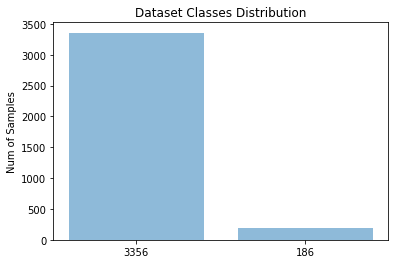

Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  149, generating: 2250
2086 images generated
Class Size :  2687, generating: 1000
992 images generated


: 

: 

In [ ]:
ensemble_model.append(train_ensemble_classifier(1,input_shape))

In [ ]:
ensemble_model.append(train_ensemble_classifier(2))

In [ ]:
ensemble_model.append(train_ensemble_classifier(3))

In [ ]:
ensemble_model.append(train_ensemble_classifier(4))

In [ ]:
ensemble_model.append(train_ensemble_classifier(5))

In [ ]:
ensemble_model.append(train_ensemble_classifier(6))

In [ ]:
ensemble_model.append(train_ensemble_classifier(7))

In [ ]:
ensemble_model.append(train_ensemble_classifier(8))

# Prediction Function for Ensemble Model

In [ ]:
def ensemble_predict(ensemble_model,X):
    #predictions = np.empty((1,X.shape[0],8))
    #[[0.3,0.7],[0.5,0.8],[0.3,0,5]] -> prediction of a class [pos neg]
    #[[0.3],[0.5],[0.3]]             -> prediction of a class [only pos]
    #now i have an array of pos for each class
    # [[0.3],[0.5],[0.3]],[[0.3],[0.5],[0.3]],[[0.3],[0.5],[0.3]] ->want the argmax for each of them
    
    predictions = []
    for model_i in ensemble_model:
        pred_i = model_i.predict(X)
        pred_i = pred_i[:,0] #Take only the (Is class i percentage, we dont want the "Is not" percentage)
        #pred_i = pred_i.reshape((1,8)) #1D array with 8 class pos prediction
        predictions.append(pred_i) # Each array appended has all predictions of a specific class binary predictor

    out = np.argmax(np.vstack(predictions), axis=0)    
        

    return out # Find the result of each pred_i[1]

# Test the Full Ensemble Model

In [ ]:

ensemble_model = test_ensemble_full(ensemble_model)


In [ ]:
def load_ensemble_model():
  ensemble_model = []
  for class_index in range(1,8):
    model_name = "ensemble-" + str(class_index)
    model_i = model_helper.load_model(model_name)
    ensemble_model.append(model_i)

  return ensemble_model

In [ ]:
ensemble_model = load_ensemble_model()